In [120]:
import pickle
from copy import deepcopy

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import numpy as np; np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize


from plot_module import plot_ODE, plot_gillespie, plot_simulator_graph, plot_neuron_graph
from sim_param_from_network import names_from_network, gillespie_param_from_network, dataframes_from_network, ODE_from_network, start_state_from_nodes
from network_generate import net_gen_line_chain, net_gen_line_ring, net_gen_line_powlawtree, net_gen_hub_ring
from neuron_graph_transform import neuron_graph_transform, add_bioparam_attributes
from simulate import simulate_ode, simulate_gillespie

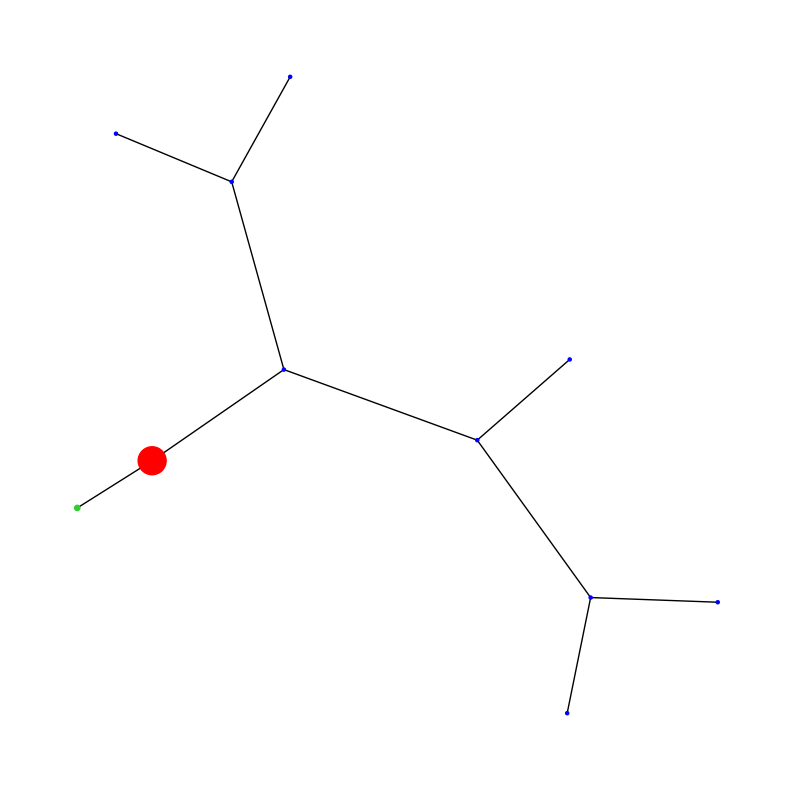

In [2]:
neuron_filename = 'm_hippocampus_NMO_97827.pkl'
with open(f'neuron_shape_data/{neuron_filename}', 'rb') as f:
    G = pickle.load(f)    

plot_neuron_graph(G)

> The undirected input graph has 11 nodes, and 10 edges, and 2 subgraph(s):
'axon with 9 nodes', 'dendrite with 1 nodes'
> the directed output graph has 14 nodes, and 28 edges


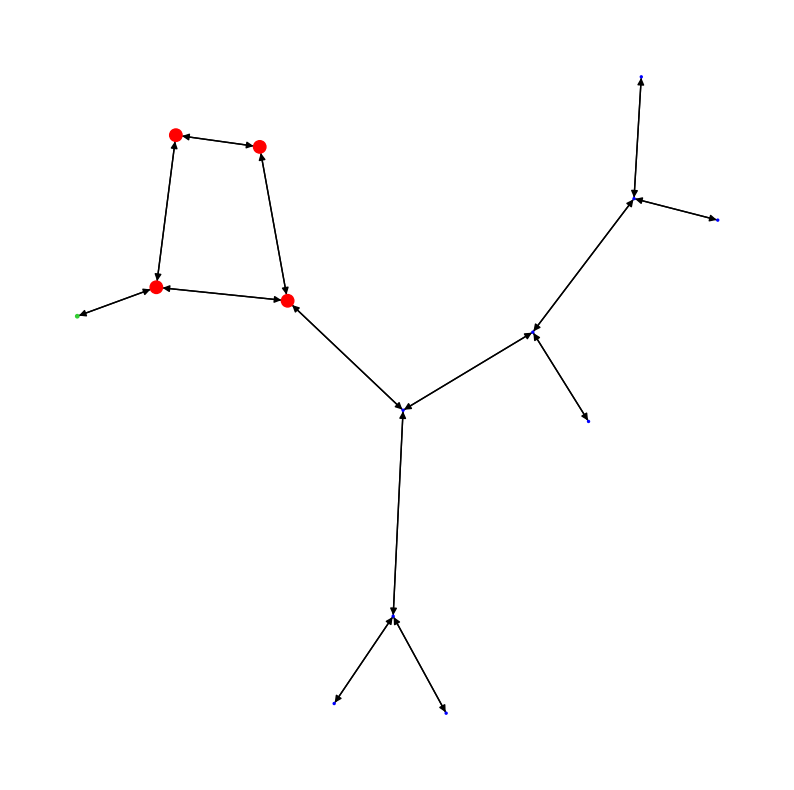

In [3]:
neuron_graph = neuron_graph_transform(G, transform_type='bidirect', n_soma_nodes=4)

plot_neuron_graph(neuron_graph)

In [4]:
TIME_POINTS = np.linspace(0, 100, 1001)

SOMA_CB = 0.5
SOMA_BR = 0.4
SOMA_NSS = 100
SOMA_DIFFUSION = 0.4

DELTA = 0.5
DEATH_RATE = 0.4

AXON_TRNSP_ANT = 8
AXON_TRNSP_RET = 6

REVERSAL_RATE = 0.001


BIO_PARAM = {
    'soma_cb':SOMA_CB, 
    'soma_br':SOMA_BR, 
    'soma_nss':SOMA_NSS,
    'soma_diffusion':SOMA_DIFFUSION,
    
    'delta':DELTA, 
    'death_rate':DEATH_RATE, 
    
    'gamma_ant':AXON_TRNSP_ANT,
    'gamma_ret':AXON_TRNSP_RET,
    
    'reversal_rate':REVERSAL_RATE,
    }

START_POP = [90, 20]

neruon_graph = add_bioparam_attributes(neuron_graph, BIO_PARAM)

#for u, v, data in neuron_graph.edges(data = True): print(f'{u}-{v}: {data}')
#for node, data in neuron_graph.nodes(data = True): print(f'{node}: {data}')

In [5]:
VARS, NODES = names_from_network(neuron_graph)
START_STATE = start_state_from_nodes(NODES, START_POP)
#START_STATE[1] = 1

>> Code for ODE model:

global ODE_model
def ODE_model(t, z):
	# variables (node name + wt/mt)
	S0_wt, S0_mt, S1_wt, S1_mt, S2_wt, S2_mt, S3_wt, S3_mt, A116_wt, A116_mt, A165_wt, A165_mt, A174_wt, A174_mt, A181_wt, A181_mt, A187_wt, A187_mt, A208_wt, A208_mt, A221_wt, A221_mt, A265_wt, A265_mt, A266_wt, A266_mt, D319_wt, D319_mt = z
	return [
		# ΔS0_wt/Δt
		(S0_wt*((0.4 + 0.5*(100-S0_wt-(0.5*S0_mt)))-(0.4)-(8.8)))+(S1_wt*0.4)+(S3_wt*0.4)+(A116_wt*6.0),
		# ΔS0_mt/Δt
		(S0_mt*((0.4 + 0.5*(100-S0_wt-(0.5*S0_mt)))-(0.4)-(8.8)))+(S1_mt*0.4)+(S3_mt*0.4)+(A116_mt*6.0),
		# ΔS1_wt/Δt
		(S1_wt*((0.4 + 0.5*(100-S1_wt-(0.5*S1_mt)))-(0.4)-(0.8)))+(S0_wt*0.4)+(S2_wt*0.4),
		# ΔS1_mt/Δt
		(S1_mt*((0.4 + 0.5*(100-S1_wt-(0.5*S1_mt)))-(0.4)-(0.8)))+(S0_mt*0.4)+(S2_mt*0.4),
		# ΔS2_wt/Δt
		(S2_wt*((0.4 + 0.5*(100-S2_wt-(0.5*S2_mt)))-(0.4)-(0.8)))+(S1_wt*0.4)+(S3_wt*0.4),
		# ΔS2_mt/Δt
		(S2_mt*((0.4 + 0.5*(100-S2_wt-(0.5*S2_mt)))-(0.4)-(0.8)))+(S1_mt*0.4)+(S3_mt*0.4),
		# ΔS3_wt/Δt
		(S3_wt*((0.4 + 0.

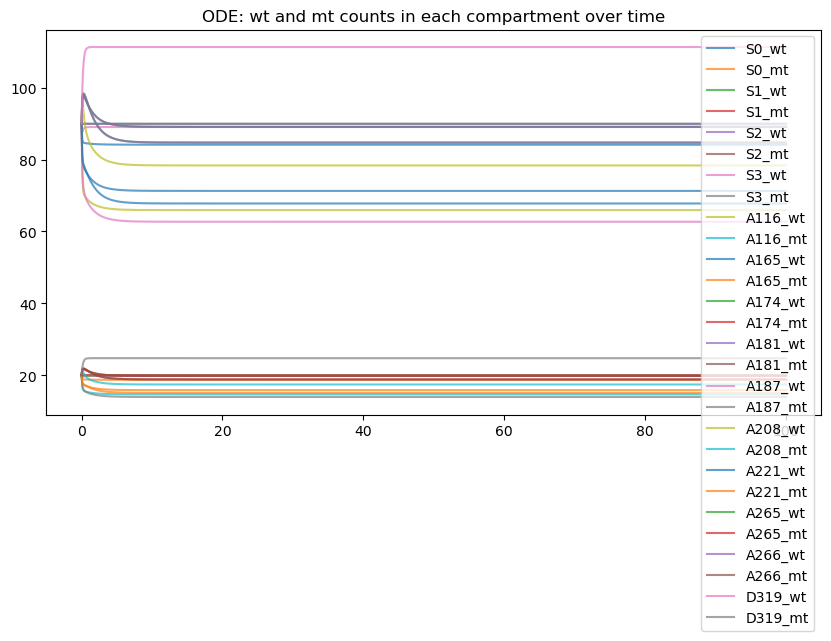

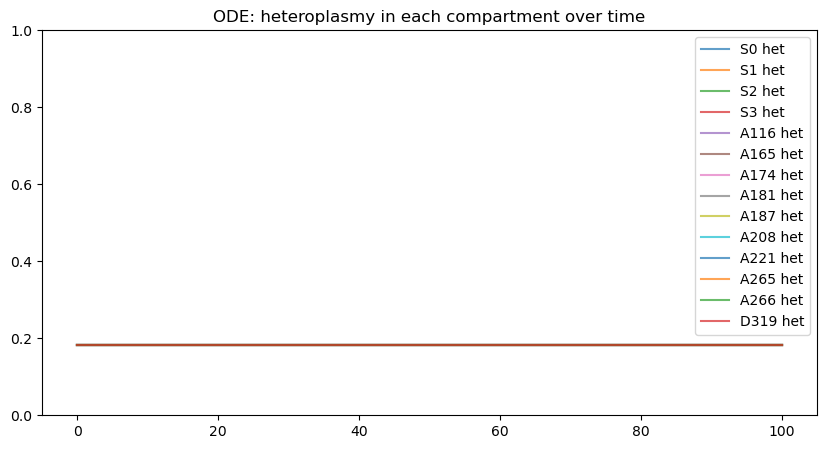

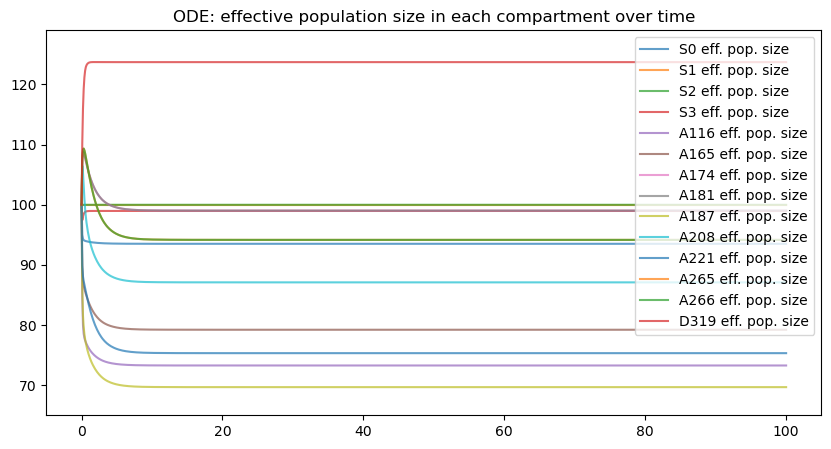

> Final counts of mt and wt in each compartment:
S0_wt	84.1553	
S0_mt	18.7012	
S1_wt	89.9539	
S1_mt	19.9898	
S2_wt	89.9923	
S2_mt	19.9983	
S3_wt	89.0678	
S3_mt	19.7928	
A116_wt	65.9498	
A116_mt	14.6555	
A165_wt	71.297	
A165_mt	15.8438	
A174_wt	89.1213	
A174_mt	19.8047	
A181_wt	89.1213	
A181_mt	19.8047	
A187_wt	62.7084	
A187_mt	13.9352	
A208_wt	78.3855	
A208_mt	17.419	
A221_wt	67.7929	
A221_mt	15.0651	
A265_wt	84.7411	
A265_mt	18.8314	
A266_wt	84.7411	
A266_mt	18.8314	
D319_wt	111.3347	
D319_mt	24.741	

> Final effective population sizes in each compartment:
S0	93.5058	
S1	99.9488	
S2	99.9914	
S3	98.9642	
A116	73.2775	
A165	79.2189	
A174	99.0237	
A181	99.0237	
A187	69.676	
A208	87.095	
A221	75.3254	
A265	94.1568	
A266	94.1568	
D319	123.7052	


In [6]:
ODE_model = ODE_from_network(neuron_graph, prnt=True)
plot_ODE(simulate_ode(ODE_model, TIME_POINTS, START_STATE), TIME_POINTS, DELTA, VARS, NODES)

simulating...


100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


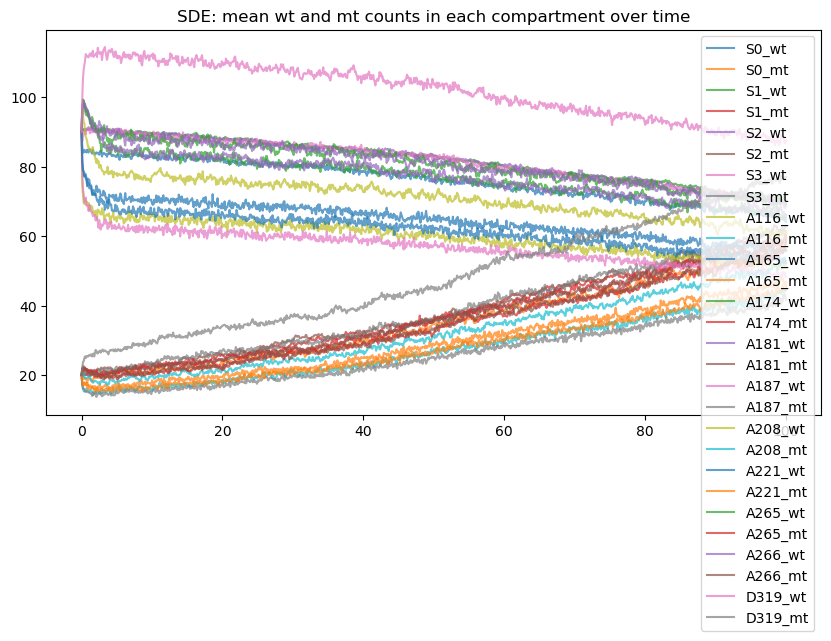

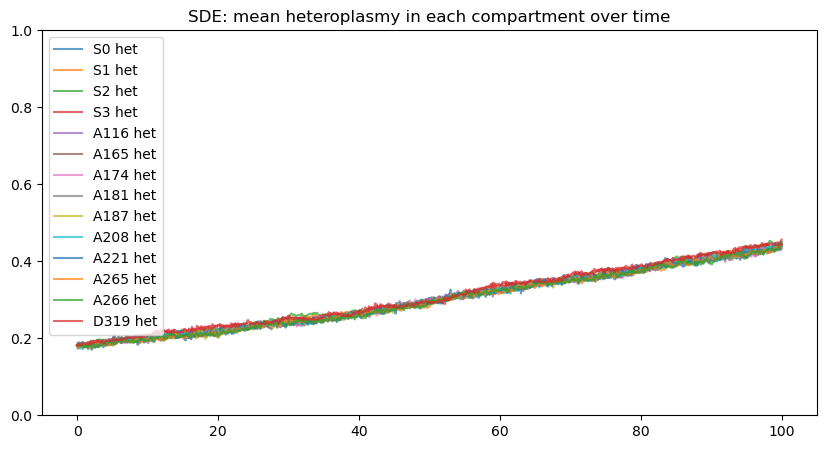

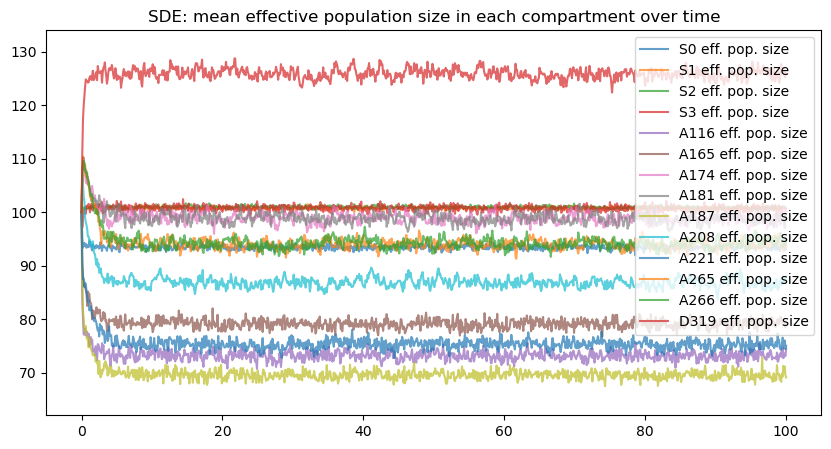

> Final mean counts of mt and wt in each compartment:
S0_wt	64.13	
S0_mt	57.91	
S1_wt	70.28	
S1_mt	60.73	
S2_wt	70.04	
S2_mt	61.32	
S3_wt	68.56	
S3_mt	63.07	
A116_wt	52.13	
A116_mt	44.49	
A165_wt	56.08	
A165_mt	46.84	
A174_wt	69.18	
A174_mt	58.52	
A181_wt	69.18	
A181_mt	59.2	
A187_wt	48.31	
A187_mt	41.52	
A208_wt	61.47	
A208_mt	53.09	
A221_wt	52.32	
A221_mt	45.4	
A265_wt	65.47	
A265_mt	55.87	
A266_wt	65.37	
A266_mt	57.86	
D319_wt	87.52	
D319_mt	77.03	

> Final mean heteroplasmy in each compartment:
S0	0.4506	
S1	0.4419	
S2	0.4455	
S3	0.4564	
A116	0.4383	
A165	0.4339	
A174	0.4366	
A181	0.4401	
A187	0.4416	
A208	0.4391	
A221	0.4435	
A265	0.4349	
A266	0.4489	
D319	0.4439	

> Final mean effective population sizes in each compartment:
S0	93.085	
S1	100.645	
S2	100.7	
S3	100.095	
A116	74.375	
A165	79.5	
A174	98.44	
A181	98.78	
A187	69.07	
A208	88.015	
A221	75.02	
A265	93.405	
A266	94.3	
D319	126.035	

> Change in mean heteroplasmy: 
start: 0.1818
final: 0.4436
delta: 0.2617


In [7]:
GILL_PARAM = gillespie_param_from_network(neuron_graph)
gillespie_results = simulate_gillespie(GILL_PARAM, TIME_POINTS, START_STATE, replicates=100)
plot_gillespie(gillespie_results, TIME_POINTS, DELTA, VARS, NODES)

S0-A116: {'edgetype': 2, 'direction': 'forward', 'rate': 8.0}
A116-A165: {'volume': 0.4764, 'len': 60.6615, 'edgetype': 2, 'direction': 'forward', 'rate': 8.0}
A116-A187: {'volume': 0.0944, 'len': 12.0149, 'edgetype': 2, 'direction': 'forward', 'rate': 8.0}
A116-S0: {'edgetype': 2, 'direction': 'reverse', 'rate': 6.0}
A165-A116: {'volume': 0.4764, 'len': 60.6615, 'edgetype': 2, 'direction': 'reverse', 'rate': 6.0}
A165-A174: {'volume': 0.1142, 'len': 14.5344, 'edgetype': 2, 'direction': 'forward', 'rate': 8.0}
A165-A181: {'volume': 0.2229, 'len': 28.3784, 'edgetype': 2, 'direction': 'forward', 'rate': 8.0}
A174-A165: {'volume': 0.1142, 'len': 14.5344, 'edgetype': 2, 'direction': 'reverse', 'rate': 6.0}
A181-A165: {'volume': 0.2229, 'len': 28.3784, 'edgetype': 2, 'direction': 'reverse', 'rate': 6.0}
A187-A116: {'volume': 0.0944, 'len': 12.0149, 'edgetype': 2, 'direction': 'reverse', 'rate': 6.0}
A187-A208: {'volume': 0.3643, 'len': 46.378, 'edgetype': 2, 'direction': 'forward', 'rate': 

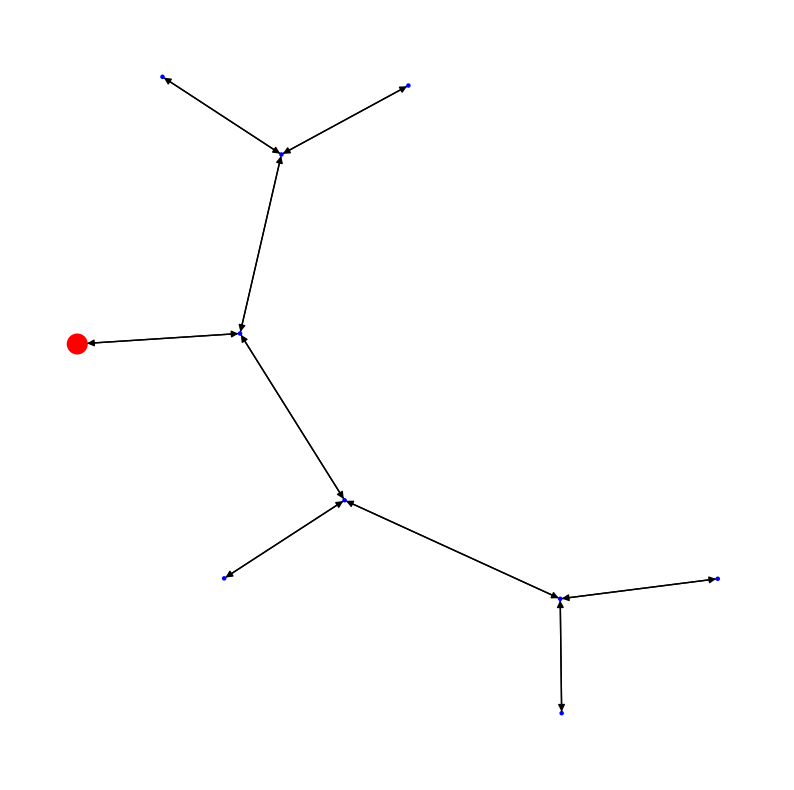

In [8]:
G = deepcopy(neuron_graph)
G.remove_node('D319')
G.remove_node('S1')
G.remove_node('S2')
G.remove_node('S3')
for u, v, data in G.edges(data = True): print(f'{u}-{v}: {data}')
for node, data in G.nodes(data = True): print(f'{node}: {data}')
plot_neuron_graph(G)

In [221]:
TARGET_AXON_TERMINAL_POP = 100
TERMINAL_INFLUX = 2*DEATH_RATE
TERMINAL_EFFLUX = DEATH_RATE

In [240]:
map_df = pd.DataFrame()

nodes = list(G.nodes())
node_to_index = {n: i for i, n in enumerate(nodes)}

edges = list(G.edges())
enumerated_edges_with_data = list(enumerate(G.edges(data = True)))

n_fluxes = len(edges)

# name of the source and destination nodes
map_df['u'] = [u for (u,v) in edges]
map_df['v'] = [v for (u,v) in edges]

# location of the rate in the flux matrix
map_df['flux_mat_i_j'] = [(node_to_index[u],node_to_index[v]) for (u,v) in edges]

# individual name of each flux variable
map_df['flux_name'] = [f'flux_{i}' for i in range(n_fluxes)]



rate = []
# iterate through the edges in the graph, and set any known terminal branch flux values
for i, (u, v, data) in enumerated_edges_with_data:
    dest_data = G.nodes(data = True)[v]
    src_data  = G.nodes(data = True)[u]
    
    # if the edge is pointing into a branch terminal, set the rate of the corresponding flux to the influx rate
    if dest_data['nodetype'] != 1 and dest_data['terminal'] == True:
        rate.append(TERMINAL_INFLUX)
    
    # if the edge is pointing away from the branch terminal, set the rate of the corresponding flux to the efflux rate
    elif src_data['nodetype'] != 1 and src_data['terminal'] == True:
        rate.append(TERMINAL_EFFLUX)
    
    # otherwise the edge has an unknown rate which must be inferred
    else:
        rate.append(np.nan)

map_df['specified_rate'] = rate

unknown_name = []
unknown_count = 0
for i in range(n_fluxes):
    if np.isnan(map_df['specified_rate'][i]):
        unknown_name.append(f'x[{unknown_count}]')
        unknown_count += 1
    else:
        unknown_name.append(None)
map_df['unknown_name'] = unknown_name
    
map_df

,u,v,flux_mat_i_j,flux_name,specified_rate,unknown_name
0,S0,A116,"(0, 1)",flux_0,NaN,x[0]
1,A116,A165,"(1, 2)",flux_1,NaN,x[1]
2,A116,A187,"(1, 5)",flux_2,NaN,x[2]
3,A116,S0,"(1, 0)",flux_3,NaN,x[3]
4,A165,A116,"(2, 1)",flux_4,NaN,x[4]
5,A165,A174,"(2, 3)",flux_5,0.8,None
6,A165,A181,"(2, 4)",flux_6,0.8,None
7,A174,A165,"(3, 2)",flux_7,0.4,None
8,A181,A165,"(4, 2)",flux_8,0.4,None
9,A187,A116,"(5, 1)",flux_9,NaN,x[5]


In [246]:
def flux_map_df_from_subnetwork(G):

    map_df = pd.DataFrame()

    nodes = list(G.nodes())
    node_to_index = {n: i for i, n in enumerate(nodes)}

    edges = list(G.edges())
    enumerated_edges_with_data = list(enumerate(G.edges(data = True)))

    n_fluxes = len(edges)

    # name of the source and destination nodes
    map_df['u'] = [u for (u,v) in edges]
    map_df['v'] = [v for (u,v) in edges]

    # location of the rate in the flux matrix
    map_df['flux_mat_i_j'] = [(node_to_index[u],node_to_index[v]) for (u,v) in edges]

    # individual name of each flux variable
    map_df['flux_name'] = [f'flux_{i}' for i in range(n_fluxes)]

    rate = []
    # iterate through the edges in the graph, and set any known terminal branch flux values
    for i, (u, v, data) in enumerated_edges_with_data:
        dest_data = G.nodes(data = True)[v]
        src_data  = G.nodes(data = True)[u]
        
        # if the edge is pointing into a branch terminal, set the rate of the corresponding flux to the influx rate
        if dest_data['nodetype'] != 1 and dest_data['terminal'] == True:
            rate.append(TERMINAL_INFLUX)
        
        # if the edge is pointing away from the branch terminal, set the rate of the corresponding flux to the efflux rate
        elif src_data['nodetype'] != 1 and src_data['terminal'] == True:
            rate.append(TERMINAL_EFFLUX)
        
        # otherwise the edge has an unknown rate which must be inferred
        else:
            rate.append(np.nan)

    # rate given by the user
    map_df['specified_rate'] = rate

    # names of the 
    unknown_name = []
    unknown_count = 0
    for i in range(n_fluxes):
        if np.isnan(map_df['specified_rate'][i]):
            unknown_name.append(f'x[{unknown_count}]')
            unknown_count += 1
        else:
            unknown_name.append(None)
    map_df['unknown_name'] = unknown_name

    return map_df

In [247]:
map_df = flux_map_df_from_subnetwork(G)

In [245]:
N = G.number_of_nodes()
nodelist = list(G.nodes())

steady_state_populations = np.full(N, 90)
steady_state_populations[0] = 200

print('Target steady state populations:')
for i in range(N): print(f'{nodelist[i]}\t\t{steady_state_populations[i]}')

print(f'Given the death rate of {DEATH_RATE}, the fluxes are the following:')
steady_state_flux = steady_state_populations*DEATH_RATE
print(steady_state_flux)


# map nodes to indeces and vice versa
node_to_index = {n: i for i, n in enumerate(nodelist)}
index_to_node = {node_to_index[n]:n for n in node_to_index}

# map edges to indeces, and vice versa. Each edge has an associated flux value
edge_to_index = {(u,v): i for i, (u,v) in enumerate(G.edges())}
index_to_edge = {v: k for k, v in edge_to_index.items()}

# map edges to the names of the flux variables, and vice versa
edge_to_fluxname = {(u,v):f'f{i}' for i, (u,v) in enumerate(G.edges())}
fluxname_to_edge = {v: k for k, v in edge_to_fluxname.items()}


fluxnames = [value for value in edge_to_fluxname.values()]
n_fluxes = len(fluxnames)


# initialize the flux vector with all unknowns
flux_vector = np.empty(n_fluxes); flux_vector[:] = np.nan

# initialize the flux matrix with all 0s
flux_matrix = np.zeros((N,N))

# iterate through the edges in the graph, and set any known terminal branch flux values
for i, (u, v, data) in enumerate(G.edges(data = True)):
    
    dest_data = G.nodes(data = True)[v]
    src_data  = G.nodes(data = True)[u]
    
    # if the edge is pointing into a branch terminal, set the rate of the corresponding flux to the influx rate
    if dest_data['nodetype'] != 1 and dest_data['terminal'] == True:
        flux_vector[edge_to_index[(u,v)]] = TARGET_AXON_TERMINAL_INFLUX
    
    # if the edge is pointing away from the branch terminal, set the rate of the corresponding flux to the efflux rate
    elif src_data['nodetype'] != 1 and src_data['terminal'] == True:
        flux_vector[edge_to_index[(u,v)]] = TARGET_AXON_TERMINAL_EFFLUX
        

print('Flux values:\nname\trate\t(source, dest)')
for i in range(n_fluxes):
    print(f'{edge_to_fluxname[index_to_edge[i]]}\t{flux_vector[i]}\t{index_to_edge[i]}\t')

    
for i, flux in enumerate(flux_vector):
    u,v = index_to_edge[i]
    flux_matrix[node_to_index[u],node_to_index[v]] = flux

print('Current flux matrix:')
print(flux_matrix)



unknown_flux_indeces = [i for i, flux in enumerate(flux_vector) if np.isnan(flux)]

unknown_flux_varnames = [fluxnames[i] for i in unknown_flux_indeces]

unknown_flux_array_indeces = {varname:i for i, varname in enumerate(unknown_flux_varnames)}

remap_unknown_flux_array = {v: k for k, v in unknown_flux_array_indeces.items()}





Target steady state populations:
S0		200
A116		90
A165		90
A174		90
A181		90
A187		90
A208		90
A221		90
A265		90
A266		90
Given the death rate of 0.4, the fluxes are the following:
[80. 36. 36. 36. 36. 36. 36. 36. 36. 36.]
Flux values:
name	rate	(source, dest)
f0	nan	('S0', 'A116')	
f1	nan	('A116', 'A165')	
f2	nan	('A116', 'A187')	
f3	nan	('A116', 'S0')	
f4	nan	('A165', 'A116')	
f5	0.8	('A165', 'A174')	
f6	0.8	('A165', 'A181')	
f7	0.4	('A174', 'A165')	
f8	0.4	('A181', 'A165')	
f9	nan	('A187', 'A116')	
f10	0.8	('A187', 'A208')	
f11	nan	('A187', 'A221')	
f12	0.4	('A208', 'A187')	
f13	nan	('A221', 'A187')	
f14	0.8	('A221', 'A265')	
f15	0.8	('A221', 'A266')	
f16	0.4	('A265', 'A221')	
f17	0.4	('A266', 'A221')	
Current flux matrix:
[[0.  nan 0.  0.  0.  0.  0.  0.  0.  0. ]
 [nan 0.  nan 0.  0.  nan 0.  0.  0.  0. ]
 [0.  nan 0.  0.8 0.8 0.  0.  0.  0.  0. ]
 [0.  0.  0.4 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.4 0.  0.  0.  0.  0.  0.  0. ]
 [0.  nan 0.  0.  0.  0.  0.8 nan 0.  0. ]
 [0.  

In [248]:
# for each node, calculate the influx and efflux terms. If they include unkowns, include them in a list of constraints
constr = '\tarray = [\n'
for i, node in enumerate(nodes):
    contains_unknown = False
    
    flux = f"\t\t# flux at {node}\n\t\t"
    
    # calculate influx rates 
    influx = ""
    for j in range(N):
        flux_rate = flux_matrix[i,j]
        if flux_rate != 0:
            # select the corresponding row in map_df
            flux_row = map_df.loc[map_df['flux_mat_i_j'] == (i,j)]
            
            # if flux rate is unknown
            if np.isnan(flux_ratio):
                contains_unknown = True
                influx += f'+({str(flux_row["unknown_name"])}*{steady_state_populations[j]})'
            # if flux rate is known 
            else:
                influx += f'+({float(flux_rate)*steady_state_populations[j]})'
    
    flux += influx
    
    # calculate efflux rates 
    efflux = ""
    for j in range(N):
        flux_rate = flux_matrix[j,i]
        if flux_rate != 0:
            # select the corresponding row in map_df
            flux_row = map_df.loc[map_df['flux_mat_i_j'] == (i,j)]
            
            # if flux rate is unknown
            if np.isnan(flux_ratio):
                contains_unknown = True
                
                flux_varname = edge_to_fluxname[(index_to_node[i],index_to_node[j])]
                efflux += f'-({str(flux_row["unknown_name"])}*{steady_state_populations[j]})'
            # if flux rate is known 
            else:
                efflux += f'-({float(flux_rate)*steady_state_populations[j]})'
    
    flux += efflux
    
    flux += f' - {steady_state_flux[i]},\n'
    if contains_unknown:
        constr += flux
    
constr += '\t\t]'
        
constr_prog = 'global flux_constrints\ndef flux_constraints(x):\n'
constr_prog += constr
constr_prog += '\n\treturn np.array(array)'

print(constr_prog)

global flux_constrints
def flux_constraints(x):
	array = [
		]
	return np.array(array)


In [157]:
bnds = [(0.1, 100) for _ in range(len(unknown_flux_varnames))]

In [138]:
def obj_to_minim(x):
    return np.sum(x)

In [166]:
global flux_constraints
flux_constraints = None
exec(constr_prog)
cons = {
    'type': 'eq', 
    'fun': flux_constraints
    }

`xtol` termination condition is satisfied.
Number of iterations: 37, function evaluations: 333, CG iterations: 80, optimality: 3.81e-01, constraint violation: 1.42e-14, execution time: 0.049 s.


/home/daniel/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [189]:
for i, flux in enumerate(optimized_fluxes):
    u, v = fluxname_to_edge[remap_unknown_flux_array[i]]
    print(u, v, flux)
    flux_matrix[node_to_index[v],node_to_index[u]] = flux

print(np.round(flux_matrix, 3))

S0 A116 0.7537947221905414
A116 A165 0.6966585974232786
A116 A187 0.6356820926608674
A116 S0 1.1537947221905416
A165 A116 1.0966585974232788
A187 A116 1.0356820926608674
A187 A221 0.7116583850959477
A221 A187 1.1116583850959476
[[0.    1.154 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.754 0.    1.097 0.    0.    1.036 0.    0.    0.    0.   ]
 [0.    0.697 0.    0.8   0.8   0.    0.    0.    0.    0.   ]
 [0.    0.    0.4   0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.4   0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.636 0.    0.    0.    0.    0.8   1.112 0.    0.   ]
 [0.    0.    0.    0.    0.    0.4   0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.712 0.    0.    0.8   0.8  ]
 [0.    0.    0.    0.    0.    0.    0.    0.4   0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.4   0.    0.   ]]
